# A Notebook for Region Aware Testing

The purpose of this notebook is to provide a way to do some preliminary region-aware MCMC work. Within
this notebook, there are some custom methods, called `weighted_spanning_tree`, 
`bipartition_weighted_tree_bounded_repeats`, and `weighted_recom_with_self_loops` which modify the 
standard methods present within `gerrychain` to allow for the addition of region aware methods.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
from networkx.algorithms import tree
import random
from functools import partial

from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain.constraints import contiguous
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.tree import (recursive_tree_part, BalanceError, PopulatedGraph,
                             find_balanced_edge_cuts_memoization)

random.seed(2023)

### Modified functions

These are the functions that needed ot be modified to make region-aware possible.
The reader may compare them to the original versions of the functions found within
`gerrychain` package. The source code for that package is available 
[here](https://github.com/mggg/GerryChain). The functions to compare these to 
can mainly be found within the files `tree.py` (`random_spanning_tree`, `bipartition_tree`)
and `tree_proposal.py` (`recom`)

In [2]:
def weighted_spanning_tree(graph, weight_dict):
    """
    Calculates the weighted spanning tree of a graph using the given weight dictionary.
    
    Parameters:
        graph (networkx.Graph): The input graph.
        weight_dict (dict): A dictionary containing weights for different attributes of the graph nodes.
    
    Note: The weight_dict should be of the form {attribute: weight} where attribute is a column in the graph's nodes and weight is a float between 0 and 1.0. Weights are additive for edges belonging to multiple categories,
        
    Returns:
        networkx.Graph: The weighted spanning tree of the input graph.
    """
    
    for edge in graph.edges():
        weight = random.random()
        
        for key, value in weight_dict.items():
            if graph.nodes[edge[0]][key] == graph.nodes[edge[1]][key] and graph.nodes[edge[0]][key] is not None:
                weight += value
        
        graph.edges[edge]["edge_weight"] = weight
    
    spanning_tree = nx.tree.maximum_spanning_tree(graph.copy(), algorithm="kruskal", weight= "edge_weight")
    return spanning_tree




def bipartition_weighted_tree_bounded_repeats(
    graph, 
    pop_col, 
    pop_target, 
    epsilon, 
    weight_dict,
    node_repeats=10, 
    spanning_tree=None, 
    choice=random.choice,
    repeats = 100
):
    """
    Finds a balanced cut in a weighted tree graph using bounded repeats.

    Args:
        graph (Graph): The input graph.
        pop_col (str): The column name representing the population attribute of each node.
        pop_target (float): The target population for each partition.
        epsilon (float): The maximum allowed deviation from the target population.
        weight_dict (dict): A dictionary mapping edges to their weights.
        node_repeats (int, optional): The number of times to restart the algorithm if no balanced cut is found. Defaults to 10.
        spanning_tree (Graph, optional): The spanning tree of the input graph. If not provided, it will be computed. Defaults to None.
        choice (function, optional): The function used for random choice. Defaults to random.choice.
        repeats (int, optional): The number of repeats to perform. Defaults to 100.

    Returns:
        set: A set of nodes representing a balanced cut, or None if no balanced cut is found.
    """
    populations = {node: graph.nodes[node][pop_col] for node in graph}
    possible_cuts = []
    if spanning_tree is None:
        spanning_tree = weighted_spanning_tree(graph, weight_dict)
    restarts = 0
    for _ in range(repeats):
        if len(possible_cuts) > 0:
            return choice(possible_cuts).subset
        if restarts == node_repeats:
            spanning_tree = weighted_spanning_tree(graph, weight_dict)
            restarts = 0
        h = PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = find_balanced_edge_cuts_memoization(h, choice=choice)
        restarts += 1
    return None   # failed to find a balanced cut after repeats



def weighted_recom_with_self_loops(
    partition, pop_col, pop_target, epsilon, 
    weight_dict = {}, 
    node_repeats=1, method=bipartition_weighted_tree_bounded_repeats
):
    """
    Performs a weighted recom with self-loops on a given partition.

    Args:
        partition (Partition): The partition object representing the current state.
        pop_col (str): The name of the column containing population data.
        pop_target (float): The target population for each district.
        epsilon (float): The allowable deviation from the target population.
        weight_dict (dict): A dictionary containing the weights for each edge in the graph.
        node_repeats (int, optional): The number of times to repeat the node balancing step. Defaults to 1.
        method (function, optional): The method to use for bipartitioning the graph. Defaults to bipartition_weighted_tree_bounded_repeats.

    Returns:
        Partition: The updated partition object after performing the weighted recom with self-loops.
    """
    
    # Picks a random district pair to merge
    edge = random.choice(tuple(partition["cut_edges"]))
    parts_to_merge = (partition.assignment[edge[0]], partition.assignment[edge[1]])

    subgraph = partition.graph.subgraph(
        partition.parts[parts_to_merge[0]] | partition.parts[parts_to_merge[1]]
    )

    try:
        flips = recursive_tree_part(
            subgraph,
            parts_to_merge,
            pop_col=pop_col,
            pop_target=pop_target,
            epsilon=epsilon,
            node_repeats=node_repeats,
            method=partial(method, weight_dict=weight_dict),
        )
    except BalanceError:
        flips = {}
        
    return partition.flip(flips)



### Start of example

In [3]:
graph = Graph.from_json("8x8_with_muni.json")

### Setting the Parameters

The following cell contains the parameters for region aware. The main thing 
that controls the regions is the weight dictionary. When creating new districts, 
`gerrychain` creates a random maximal spanning tree using Kruskal's algorithm.
The vanilla version of gerrychain just assigns a random number between 0 and 1
to each edge of the graph and then applies Kruskal, but in the region-aware 
version, we upweight the edges according to a dictionary of regions and 
the value by which we wish to upweight the edge. So an example dictionary might 
look something like

```
my_weights = {region_label_1: region_wgt_1, ... , region_label_k: region_wgt_k}
```

By upweighting edges that are within a particular region, edges interior to that 
region tend to be selected first. Then when we attempt to pick a balanced edge 
to cut at, the edges that lie between regions are more likely to be picked since 
the regions themselves will act as population clusters that are more difficult 
to split.

As a note, since we start by assigning a random weight in $[0,1]$ to the edges,
it is not generally necessary to assign weights to regions above the value of $1.0$
(though, there can be situations where this is warranted). Also, weights are additive,
so if some adjacent nodes $N_1$ and $N_2$ belong to two regions $R_1$ and $R_2$ 
with weights $w_1$ and $w_2$, then the edge $(N_1,N_2)$ will be upweighted by 
$w_1 + w_2$. Thus, it is generally recommended that weights for overlapping 
regions do not add up to more than $1.0$.

In [4]:
num_districts = 8
pop_bound = 0.025

num_steps = 5000

population_col = "TOTPOP" 

my_weights = {"county": 0.0, 
              "muni": 1.0}

In [5]:
my_updaters = {"population": updaters.Tally(population_col, alias="population"),
               "cut_edges": cut_edges}

initial_partition = Partition(graph,
                              assignment="district",
                              updaters=my_updaters,
)
ideal_pop = sum(initial_partition["population"].values())/len(initial_partition)

In [6]:
weighted_proposal = partial(weighted_recom_with_self_loops,
                            pop_col=population_col,
                            pop_target=ideal_pop,
                            epsilon=pop_bound,
                            weight_dict=my_weights,
                            node_repeats=10,
                            method=bipartition_weighted_tree_bounded_repeats)


weighted_chain = MarkovChain(proposal=weighted_proposal,
                             constraints=[contiguous],
                             accept=accept.always_accept,
                             initial_state=initial_partition,
                             total_steps=num_steps)

In [7]:
end_assign = {}

for i, item in enumerate(weighted_chain):
    print(f"{i+1}/{num_steps}", end='\r') # This just allows for monitoring of the number of steps
    end_assign = dict(item.assignment)
    

### Note on the Graph

Compare the following graph to the included png files that show that municipalities 
and the counties. It would be good to play with different weights in the `my_weights` 
dict and see how the resulting districts fit to the underlying structure.

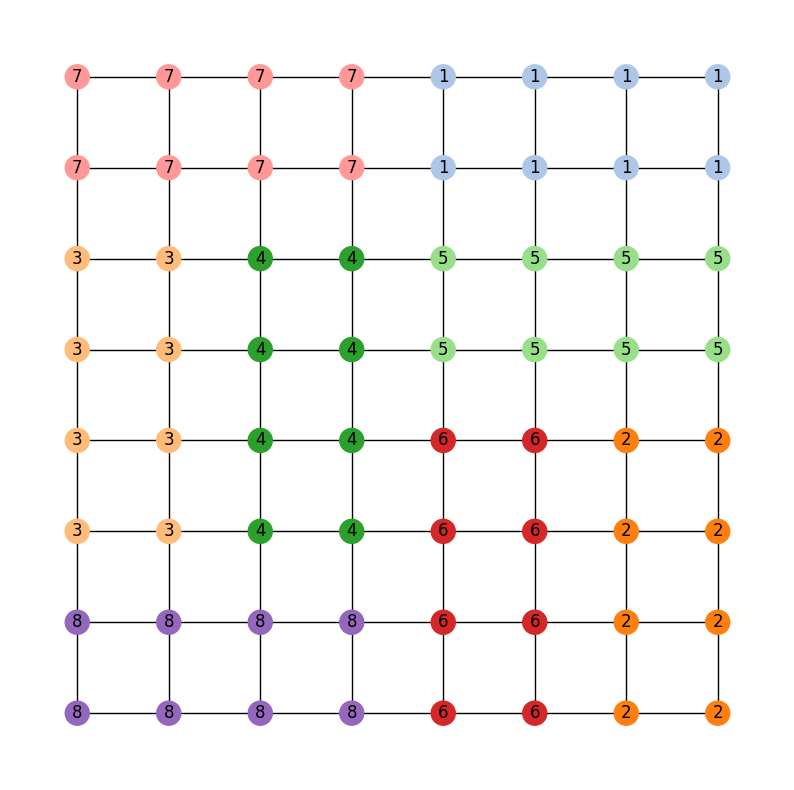

In [8]:
plt.figure(figsize=(10,10))


pos = {node :(data['x'],data['y']) for node, data in graph.nodes(data=True)}  # positions for all nodes
# node_colors = [mcm.tab20(int(data['county'])%20) for node, data in graph.nodes(data=True) ]
# node_colors = [mcm.tab20(int(data['district'])%20) for node, data in graph.nodes(data=True) ]
# node_colors = [mcm.inferno(data['precinct']/9.0) for node, data in graph.nodes(data=True) ]
# node_colors = [mcm.tab20(int(data['muni'])%20) for node, data in graph.nodes(data=True) ]
node_colors = [mcm.tab20(int(value)%20) for key,value in end_assign.items()]

# node_labels = {node: str(data['county']) for node, data in graph.nodes(data=True)}
# node_labels = {node: str(data['district']) for node, data in graph.nodes(data=True)}
# node_labels = {node: str(data['precinct']) for node, data in graph.nodes(data=True)}
# node_labels = {node: str(data['muni']) for node, data in graph.nodes(data=True)}
node_labels = end_assign

nx.draw_networkx_nodes(graph, pos, node_color=node_colors)
nx.draw_networkx_edges(graph, pos)

nx.draw_networkx_labels(graph, pos, labels=node_labels)
plt.axis('off')
plt.show()